# ZSAMC Liquidity Forecasting and Stress Test
In this section we would try to simulate the process of real life financial instrument cashflow generation. Originally, the financial instrument cashflow is predetermined, but real life scenarios make random change to cashflow dynamic, like default and deference. Now we have some data about historical cashflow patterns, with predetermined parameters(term, interest, principal) and random hyperparameters(default rate, defer rate, extenet term, etc). Each cashflow time series is like one stochastic process path, and every time spot the stochastic process has different status parameters.
We will use Monte Carlo simulation to find multiple paths to calculate mean cashflow and extreme low cashflow. To make the process variable, the simulation would introduce hyperparameters in ranges which is determined from calibration module, thus the paths would spread and generate extreme results. Now we can generate variable influence factors and extenet terms for tradable asset, but we still choose fixed default rate, recovery rate, and defer rate, which cannnot create the variable paths we want, maybe such decision making factors should also has range, influcenced by external.

# Import

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from joblib import Parallel, delayed

# Read Historical Data from Excel

In [29]:
'''
# Read historical data for fixed income assets from Excel file
historical_data_fixed_income = pd.read_excel('historical_data_fixed_income.xlsx', index_col=0).transpose()

# Read historical data for tradable assets from Excel file
historical_data_tradable = pd.read_excel('historical_data_tradable.xlsx', index_col=0).transpose()

# Read external factors data from Excel file
external_factors = pd.read_excel('external_factors.xlsx')

# Read cash outflows data from Excel file
cash_outflows = pd.read_excel('cash_outflows.xlsx', index_col=0).transpose()
'''

"\n# Read historical data for fixed income assets from Excel file\nhistorical_data_fixed_income = pd.read_excel('historical_data_fixed_income.xlsx', index_col=0).transpose()\n\n# Read historical data for tradable assets from Excel file\nhistorical_data_tradable = pd.read_excel('historical_data_tradable.xlsx', index_col=0).transpose()\n\n# Read external factors data from Excel file\nexternal_factors = pd.read_excel('external_factors.xlsx')\n\n# Read cash outflows data from Excel file\ncash_outflows = pd.read_excel('cash_outflows.xlsx', index_col=0).transpose()\n"

# Fixed Income Asset Data Generate

In [30]:
import numpy as np
import pandas as pd

# Parameters
num_assets = 20
max_term_months = 60
interest_rate_min = 0.08
interest_rate_max = 0.15
annual_default_rate_min = 0.01
annual_default_rate_max = 0.1
recovery_rate_min = 0.3
recovery_rate_max = 0.7
defer_rate_min = 0.1
defer_rate_max = 0.3
defer_period_min = 12
defer_period_max = 24

# Convert annual default rate to monthly default rate
monthly_default_rate_min = 1 - (1 - annual_default_rate_min) ** (1 / 12)
monthly_default_rate_max = 1 - (1 - annual_default_rate_max) ** (1 / 12)

# Generate random principal amounts for each asset
principal_amounts = np.random.uniform(1000, 10000, num_assets)

# Generate random interest rates for each asset
interest_rates = np.random.uniform(interest_rate_min, interest_rate_max, num_assets)

# Calculate fixed monthly interest for each asset
monthly_interests = principal_amounts * interest_rates / 12

# Generate random terms for each asset within the maximum term
terms = np.random.randint(1, max_term_months + 1, num_assets)

# Generate random intake times between 2014-01-01 and 2020-01-01
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2020-01-01')
intake_times = pd.to_datetime(np.random.randint(start_date.value // 10**9, end_date.value // 10**9, num_assets), unit='s')

# Initialize the cash inflow matrices
cash_inflows_defaultable = np.zeros((num_assets, max_term_months + defer_period_max))
cash_inflows_default_free = np.zeros((num_assets, max_term_months))

# Generate random cash inflows
for i in range(num_assets):
    default_occurred = False
    for j in range(terms[i]):
        # Generate random default rate and recovery rate for each asset at each month
        default_rate = np.random.uniform(monthly_default_rate_min, monthly_default_rate_max)
        recovery_rate = np.random.uniform(recovery_rate_min, recovery_rate_max)
        defer_rate = np.random.uniform(defer_rate_min, defer_rate_max)
        defer_period = np.random.randint(defer_period_min, defer_period_max + 1)
        if default_occurred:
            inflow_defaultable = 0
        else:
            if np.random.rand() < default_rate: # Default occurred
                if np.random.rand() < defer_rate: # Defer occurred
                    for k in range(j, j + defer_period):
                        if k< max_term_months + defer_period_max:
                            cash_inflows_defaultable[i, k] = monthly_interests[i]
                    cash_inflows_defaultable[i, j + defer_period] = principal_amounts[i]
                    break
                else: # Default and recovery immediately
                    inflow_defaultable = principal_amounts[i] * recovery_rate
                    default_occurred = True
            else:
                inflow_defaultable = monthly_interests[i]
        
        inflow_default_free = monthly_interests[i]
        
        cash_inflows_defaultable[i, j] = inflow_defaultable if j < terms[i] - 1 else inflow_defaultable + principal_amounts[i]
        cash_inflows_default_free[i, j] = inflow_default_free if j < terms[i] - 1 else inflow_default_free + principal_amounts[i]

# Convert to DataFrames for better readability
fixed_cash_inflows_defaultable_df = pd.DataFrame(cash_inflows_defaultable, columns=[f'Month_{i+1}' for i in range(max_term_months + defer_period_max)])
fixed_cash_inflows_default_free_df = pd.DataFrame(cash_inflows_default_free, columns=[f'Month_{i+1}' for i in range(max_term_months)])

# Add additional information columns
for df in [fixed_cash_inflows_defaultable_df, fixed_cash_inflows_default_free_df]:
    df.insert(0, 'Asset', [f'Asset_{i+1}' for i in range(num_assets)])
    df.insert(1, 'Principal', principal_amounts)
    df.insert(2, 'Interest_Rate', interest_rates)
    df.insert(3, 'Term', terms)
    df.insert(4, 'Intake_Time', intake_times)

# Display the first few rows of each DataFrame
print("Defaultable Cashflows:")
print(fixed_cash_inflows_defaultable_df.head())

print("\nDefault-Free Cashflows:")
print(fixed_cash_inflows_default_free_df.head())

# calculate one year sum of default free cashflow to one number
one_year_sum = fixed_cash_inflows_default_free_df.iloc[:, 1:13].sum(axis=1).sum(axis=0)
print("\nOne year sum of default free cashflow:")
print(one_year_sum)


Defaultable Cashflows:
     Asset    Principal  Interest_Rate  Term         Intake_Time    Month_1  \
0  Asset_1  8179.254115       0.090928    50 2017-09-05 09:55:06  61.976608   
1  Asset_2  3742.441632       0.134962    34 2014-01-16 11:53:04  42.090600   
2  Asset_3  9823.040037       0.092158    20 2017-08-02 11:25:49  75.439669   
3  Asset_4  4907.856555       0.094635    32 2017-11-28 10:05:05  38.704623   
4  Asset_5  1139.064960       0.096730    50 2019-08-24 02:58:04   9.181791   

     Month_2    Month_3    Month_4    Month_5  ...  Month_75  Month_76  \
0  61.976608  61.976608  61.976608  61.976608  ...       0.0       0.0   
1  42.090600  42.090600  42.090600  42.090600  ...       0.0       0.0   
2  75.439669  75.439669  75.439669  75.439669  ...       0.0       0.0   
3  38.704623  38.704623  38.704623  38.704623  ...       0.0       0.0   
4   9.181791   9.181791   9.181791   9.181791  ...       0.0       0.0   

   Month_77  Month_78  Month_79  Month_80  Month_81  Mont

/var/folders/g2/r5l525b14hd7tndcl308wcgh0000gn/T/ipykernel_96030/2753392409.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  one_year_sum = fixed_cash_inflows_default_free_df.iloc[:, 1:13].sum(axis=1).sum(axis=0)


# Tradable Asset Data Generate

In [31]:
import numpy as np
import pandas as pd

# Parameters for tradable assets
num_tradable_assets = 20
max_term_months = 60
disposal_return_min = 0.3
disposal_return_max = 0.5
disposal_term_min = 6
disposal_term_max = 60
influence_factor_min = 0.9
influence_factor_max = 1.1
defer_rate = 0.2  # Probability of deferring the disposal term
defer_period_min = 1  # Minimum defer period in months
defer_period_max = 12  # Maximum defer period in months

# Generate random principal amounts for each tradable asset
tradable_principal_amounts = np.random.uniform(1000, 10000, num_tradable_assets)

# Generate random disposal returns for each tradable asset
disposal_returns = np.random.uniform(disposal_return_min, disposal_return_max, num_tradable_assets)

# Generate random disposal terms for each tradable asset within the maximum term
disposal_terms = np.random.randint(disposal_term_min, disposal_term_max + 1, num_tradable_assets)

# Generate random influence factors for each tradable asset
influence_factors = np.random.uniform(influence_factor_min, influence_factor_max, num_tradable_assets)

# Initialize the cash inflow matrices for tradable assets
deviated_cash_inflows = np.zeros((num_tradable_assets, max_term_months + defer_period_max))
deviation_free_cash_inflows = np.zeros((num_tradable_assets, max_term_months))

# Generate random cash inflows
for i in range(num_tradable_assets):
    projected_cash_collection = tradable_principal_amounts[i] * (1 + disposal_returns[i])
    influenced_cash_collection = projected_cash_collection * influence_factors[i]
    remaining_inflow_deviated = influenced_cash_collection
    remaining_inflow_free = projected_cash_collection
    
    # Determine if the disposal term will be deferred
    if np.random.rand() < defer_rate:
        defer_period = np.random.randint(defer_period_min, defer_period_max + 1)
        disposal_terms[i] += defer_period
        disposal_terms[i] = min(disposal_terms[i], max_term_months)  # Ensure it does not exceed max_term_months
    
    for j in range(disposal_terms[i] - 1):
        inflow_deviated = np.random.uniform(0, remaining_inflow_deviated / (disposal_terms[i] - j))
        inflow_free = np.random.uniform(0, remaining_inflow_free / (disposal_terms[i] - j))
        deviated_cash_inflows[i, j] = inflow_deviated
        deviation_free_cash_inflows[i, j] = inflow_free
        remaining_inflow_deviated -= inflow_deviated
        remaining_inflow_free -= inflow_free
    
    # Ensure the last month's inflow makes the total equal to influenced_cash_collection and projected_cash_collection
    deviated_cash_inflows[i, disposal_terms[i] - 1] = remaining_inflow_deviated
    deviation_free_cash_inflows[i, disposal_terms[i] - 1] = remaining_inflow_free

# Convert to DataFrames for better readability
deviated_cash_inflows_df = pd.DataFrame(deviated_cash_inflows, columns=[f'Month_{i+1}' for i in range(max_term_months + defer_period_max)])
deviation_free_cash_inflows_df = pd.DataFrame(deviation_free_cash_inflows, columns=[f'Month_{i+1}' for i in range(max_term_months)])

# Add additional information columns
for df in [deviated_cash_inflows_df, deviation_free_cash_inflows_df]:
    df.insert(0, 'Asset', [f'Tradable_Asset_{i+1}' for i in range(num_tradable_assets)])
    df.insert(1, 'Principal', tradable_principal_amounts)
    df.insert(2, 'Disposal_Return', disposal_returns)
    df.insert(3, 'Disposal_Term', disposal_terms)
    if df is deviated_cash_inflows_df:
        df.insert(4, 'Influence_Factor', influence_factors)

# Display the first few rows of each DataFrame
print("Deviated Cashflows (Affected by Influence Factor):")
print(deviated_cash_inflows_df.head())

print("\nDeviation-Free Cashflows (Not Affected by Influence Factor):")
print(deviation_free_cash_inflows_df.head())

Deviated Cashflows (Affected by Influence Factor):
              Asset    Principal  Disposal_Return  Disposal_Term  \
0  Tradable_Asset_1  2563.041473         0.470421             54   
1  Tradable_Asset_2  1257.448271         0.489309             51   
2  Tradable_Asset_3  9690.883174         0.383645             60   
3  Tradable_Asset_4  6787.046466         0.310743             41   
4  Tradable_Asset_5  9457.738925         0.346974             16   

   Influence_Factor     Month_1     Month_2     Month_3     Month_4  \
0          1.047527   67.324414    1.354877    4.694632   62.017299   
1          1.075368    0.037442   24.861991   21.561078   26.803868   
2          1.011697  120.683271  100.114174   91.517508  206.147678   
3          1.079348  129.721346   59.597582   70.709094   80.008869   
4          1.045819  288.288361  171.894632  416.859365    5.902660   

      Month_5  ...  Month_63  Month_64  Month_65  Month_66  Month_67  \
0   72.596358  ...       0.0       0.0   

Given real cashflow and hypothestic cashflow, we want to know the optimized hyperparameters, which altering the hypothestic cashflow. Once we reach the hyperparameters, we add randomness to cashflow generation process, and generate extreme cashflow.

# Find Best Fit Hyperparameters

In [32]:
def calculate_defaultable_cashflow(df, annual_default_rate_min, annual_default_rate_max, recovery_rate_min, recovery_rate_max, defer_rate_min, defer_rate_max, defer_period_min, defer_period_max):
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Make sure defer period is integer
    defer_period_min = int(defer_period_min)
    defer_period_max = int(defer_period_max)

    # Convert annual default rate to monthly default rate
    monthly_default_rate_min = 1 - (1 - annual_default_rate_min) ** (1 / 12)
    monthly_default_rate_max = 1 - (1 - annual_default_rate_max) ** (1 / 12)
                                    
    # Initialize the cash inflow matrix, excluding the additional information columns
    cash_inflows = np.zeros((df_copy.shape[0], df_copy.shape[1] - 5 + defer_period_max))
    
    # Generate random cash inflows
    for i in range(df_copy.shape[0]):
        # Initialize default_occurred flag for each asset
        default_occurred = False
        for j in range(df_copy.iloc[i, 3]): # Iterate over the term of each asset
            # Generate random default rate, recovery rate, and defer rate for each asset at each month
            default_rate = np.random.uniform(monthly_default_rate_min, monthly_default_rate_max)
            recovery_rate = np.random.uniform(recovery_rate_min, recovery_rate_max)
            defer_rate = np.random.uniform(defer_rate_min, defer_rate_max)
            defer_period = np.random.randint(int(defer_period_min), int(defer_period_max) + 1)
            
            if default_occurred:
                inflow = 0
            else:
                if np.random.rand() < default_rate: # Default occurred
                    if np.random.rand() < defer_rate:  # Defer default
                        for k in range(j, j + defer_period):
                            if k < cash_inflows.shape[1]:
                                cash_inflows[i, k] = df_copy.iloc[i, 2] * df_copy.iloc[i, 1] / 12
                        if j + defer_period < cash_inflows.shape[1]:
                            cash_inflows[i, j + defer_period] = df_copy.iloc[i, 1]
                        break
                    else: 
                        inflow = df_copy.iloc[i, 1] * recovery_rate
                        default_occurred = True
                else:
                    inflow = df_copy.iloc[i, 2] * df_copy.iloc[i, 1] / 12
            
            cash_inflows[i, j] = inflow if j < df_copy.iloc[i, 3] - 1 else inflow + df_copy.iloc[i, 1]
    
    # Convert to DataFrame for better readability
    columns = [f'Month_{i+1}' for i in range(df_copy.shape[1] - 5 + defer_period_max)]
    cash_inflows_df = pd.DataFrame(cash_inflows, columns=columns)

    return cash_inflows_df

In [33]:
def calculate_tradable_cashflow(df, influence_factor_min, influence_factor_max, defer_rate, defer_period_min, defer_period_max):
    # Make sure defer period is integer
    defer_period_min = int(defer_period_min)
    defer_period_max = int(defer_period_max)
    # Initialize cashflow matrix
    cash_inflows = np.zeros((df.shape[0], df.shape[1] - 4 + defer_period_max))
    # Create a copy of the necessary columns to avoid modifying the input DataFrame
    df_copy = df.copy()
    
    for i in range(df_copy.shape[0]):
        projected_cash_collection = df_copy.iloc[i, 1] * (1 + df_copy.iloc[i, 2])
        influenced_cash_collection = projected_cash_collection * np.random.uniform(influence_factor_min, influence_factor_max)
        remaining_inflow_deviated = influenced_cash_collection

        # Determine if the disposal term will be deferred
        if np.random.rand() < defer_rate:
            defer_period = np.random.randint(defer_period_min, defer_period_max + 1)
            df_copy.iloc[i, 3] += defer_period
            df_copy.iloc[i, 3] = min(df_copy.iloc[i, 3], df_copy.shape[1] - 4)  # Ensure it does not exceed the number of months

        for j in range(df_copy.iloc[i, 3] - 1):
            inflow_deviated = np.random.uniform(0, remaining_inflow_deviated / (df_copy.iloc[i, 3] - j))
            cash_inflows[i, j] = inflow_deviated
            remaining_inflow_deviated -= inflow_deviated

        # Ensure the last month's inflow makes the total equal to influenced_cash_collection and projected_cash_collection
        cash_inflows[i, df_copy.iloc[i, 3] - 1] = remaining_inflow_deviated
    
    # Convert to DataFrame for better readability
    columns = [f'Month_{i+1}' for i in range(df_copy.shape[1] - 4 + defer_period_max)]
    cash_inflows_df = pd.DataFrame(cash_inflows, columns=columns)
    return cash_inflows_df

In [34]:
def loss_function(params, df, real_cashflows, asset_type):
    if asset_type == 'defaultable':
        predicted_cashflow = calculate_defaultable_cashflow(df, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7])
    elif asset_type == 'tradable':
        predicted_cashflow = calculate_tradable_cashflow(df, params[0], params[1], params[2], params[3], params[4])
    else:
        raise ValueError("Invalid asset type specified")
    
    # Adjust the shape of the smaller one
    if predicted_cashflow.shape[1] > real_cashflows.shape[1]:
        padding = np.zeros((real_cashflows.shape[0], predicted_cashflow.shape[1] - real_cashflows.shape[1]))
        real_cashflows_padded = np.hstack((real_cashflows.values, padding))
        predicted_cashflow_padded = predicted_cashflow.values
    elif predicted_cashflow.shape[1] < real_cashflows.shape[1]:
        padding = np.zeros((predicted_cashflow.shape[0], real_cashflows.shape[1] - predicted_cashflow.shape[1]))
        predicted_cashflow_padded = np.hstack((predicted_cashflow.values, padding))
        real_cashflows_padded = real_cashflows.values
    else:
        predicted_cashflow_padded = predicted_cashflow.values
        real_cashflows_padded = real_cashflows.values
    
    rmse = np.sqrt(np.mean((predicted_cashflow_padded - real_cashflows_padded) ** 2))
    return rmse

# calibration module

In [35]:
# Example usage
# Assuming fixed_cash_inflows_default_free_df and real_defaultable_cashflows_df are already defined
real_defaultable_cashflows = fixed_cash_inflows_defaultable_df.iloc[:, 5:]  # Extracting cashflow columns

# Initial guess for default rate and recovery rate
defaultable_initial_guess = [0.01, 0.1, 0.3, 0.7, 0.1, 0.3, 12, 24]

# Bounds for default rate and recovery rate
defaultable_bounds = [(0.005, 0.015), (0.09, 0.11), (0.2, 0.4), (0.6, 0.8), (0.05, 0.15), (0.25, 0.35), (9, 18), (18, 36)]

# Run optimization
result = minimize(loss_function, defaultable_initial_guess, args=(fixed_cash_inflows_default_free_df, real_defaultable_cashflows, 'defaultable'), bounds=defaultable_bounds, method='L-BFGS-B')

'''
# Define the parameter space for Bayesian optimization
space = [
    Real(0.005, 0.015, name='default_rate_min'),
    Real(0.09, 0.11, name='default_rate_max'),
    Real(0.2, 0.4, name='recovery_rate_min'),
    Real(0.6, 0.8, name='recovery_rate_max'),
    Real(0.05, 0.15, name='defer_rate_min'),
    Real(0.25, 0.35, name='defer_rate_max'),
    Integer(9, 18, name='defer_period_min'),
    Integer(18, 36, name='defer_period_max')
]

# warpper for optimization
def loss_warpper(params_list):
    params_dict = {
        'default_rate_min': params_list[0],
        'default_rate_max': params_list[1],
        'recovery_rate_min': params_list[2],
        'recovery_rate_max': params_list[3],
        'defer_rate_min': params_list[4],
        'defer_rate_max': params_list[5],
        'defer_period_min': params_list[6],
        'defer_period_max': params_list[7]
    }
    return loss_function(params_dict, fixed_cash_inflows_default_free_df, real_defaultable_cashflows, 'defaultable')

# Run Bayesian optimization
result = gp_minimize(loss_warpper, space, n_calls=100, random_state=0, n_jobs=-1)

'''
# Best fit parameters
best_defaultable_params = result.x
print("Best fit parameters:", best_defaultable_params)


Best fit parameters: [1.00000031e-02 1.00000006e-01 2.99999937e-01 7.00000063e-01
 1.00000031e-01 2.99999969e-01 1.20000038e+01 2.39999962e+01]


In [36]:
real_tradable_cashflows = deviated_cash_inflows_df.iloc[:, 5:]  # Extracting cashflow columns
tradable_initial_guess = [0.8, 1.4, 0.5, 4, 10]
tradable_bounds = [(0.0, 1.0), (1.0, 2.0), (0.0, 1.0), (0, 6), (6, 24)]

# Assuming loss_function is defined elsewhere and correctly handles 'tradable' asset type
result = minimize(loss_function, tradable_initial_guess, args=(deviation_free_cash_inflows_df, real_tradable_cashflows, 'tradable'), bounds=tradable_bounds, method='L-BFGS-B')

best_influence_factor_min, best_influence_factor_max, best_defer_rate, best_defer_period_min, best_defer_period_max = result.x
print("Best influence factor min:", best_influence_factor_min)
print("Best influence factor max:", best_influence_factor_max)
print("Best defer rate:", best_defer_rate)
print("Best defer period min:", best_defer_period_min)
print("Best defer period max:", best_defer_period_max)
print("Loss:", result.fun)

Best influence factor min: 0.8000000733176043
Best influence factor max: 1.3999998533660014
Best defer rate: 0.500000183283823
Best defer period min: 4.000000733151404
Best defer period max: 10.000005132046498
Loss: 310.89840989668204


# Monte Carlo Simulation for Defaultable Asset

Whole term sum of mean cashflows:
131112.92934664822
Mean cashflows:
0     1101.933879
1     1088.026160
2     1068.805404
3     1056.054099
4     1067.084297
         ...     
91       0.000000
92       0.000000
93       0.000000
94       0.000000
95       0.000000
Length: 96, dtype: float64
Whole term sum of extreme low cashflows:
126002.7848191535
Extreme low cashflows:
0     919.079493
1     919.079493
2     919.079493
3     919.079493
4     919.079493
         ...    
91      0.000000
92      0.000000
93      0.000000
94      0.000000
95      0.000000
Name: 639, Length: 96, dtype: float64


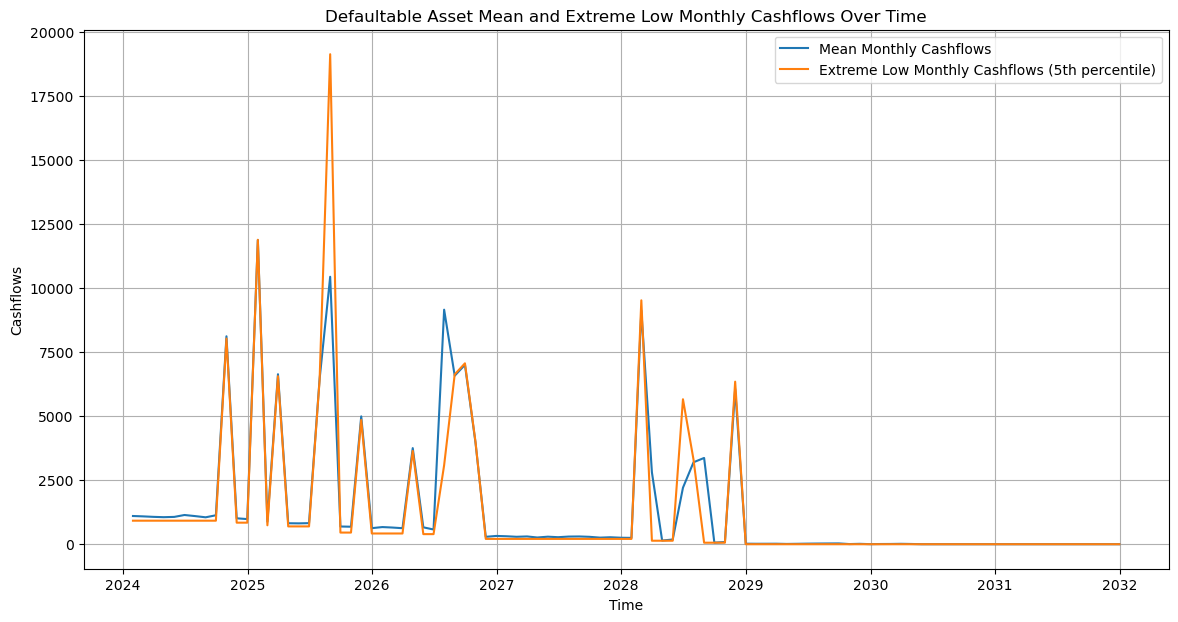

In [37]:
# Defaultable Asset Monte Carlo Simulation
num_paths = 1000
num_steps = fixed_cash_inflows_default_free_df.iloc[:, 5:].shape[1] + 36 # make sure max defer period is considered
forecast_period = 12  # Forecast cashflows for the next 12 months
cashflow_sums = np.zeros(num_paths)
extreme_low_cashflow_sums = np.zeros(num_paths)

monthly_cashflows = pd.DataFrame(index=range(num_steps), columns=range(num_paths))

for i in range(num_paths):
    cashflows_df = calculate_defaultable_cashflow(fixed_cash_inflows_default_free_df, *best_defaultable_params)
    simulated_cashflows = cashflows_df.sum(axis=0).values # Sum cashflows over all assets to exhibit portfolio liquidity performance
    
    # Ensure the lengths match by padding with zeros if necessary
    if len(simulated_cashflows) < num_steps:
        padding = np.zeros(num_steps - len(simulated_cashflows))
        simulated_cashflows = np.hstack((simulated_cashflows, padding))
    elif len(simulated_cashflows) > num_steps: # actually this should not happen
        simulated_cashflows = simulated_cashflows[:num_steps]
    
    monthly_cashflows[i] = simulated_cashflows
    cashflow_sums[i] = np.sum(simulated_cashflows)


# Calculate the monthly dynamic cashflows
mean_monthly_cashflows = monthly_cashflows.mean(axis=1)
# Search all paths, and find the one with 5th lowest cashflow sums value, return the path index
extreme_low_cashflow_path_index = np.argsort(cashflow_sums)[4]
extreme_low_monthly_cashflows = monthly_cashflows[extreme_low_cashflow_path_index]

# Print the whole term sum of mean and extreme low cashflows
print("Whole term sum of mean cashflows:")
print(np.sum(mean_monthly_cashflows))
print("Mean cashflows:")
print(mean_monthly_cashflows)
print("Whole term sum of extreme low cashflows:")
print(np.sum(extreme_low_monthly_cashflows))
print("Extreme low cashflows:")
print(extreme_low_monthly_cashflows)

# Create index for the monthly cashflows
monthly_cashflows.index = pd.date_range(start='2024-01-01', periods=num_steps, freq='M')

# Plot the default free, mean, and extreme low monthly cashflows over time
plt.figure(figsize=(14, 7))
plt.plot(monthly_cashflows.index, mean_monthly_cashflows, label='Mean Monthly Cashflows')
plt.plot(monthly_cashflows.index, extreme_low_monthly_cashflows, label='Extreme Low Monthly Cashflows (5th percentile)')
plt.xlabel('Time')
plt.ylabel('Cashflows')
plt.title('Defaultable Asset Mean and Extreme Low Monthly Cashflows Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Monte Carlo Simulation for Tradable Asset

Expected one-year cashflow (Tradabale): 44026.825149336524
Extreme low one-year cashflow (Tradabale) (5th percentile): 36008.284242846916


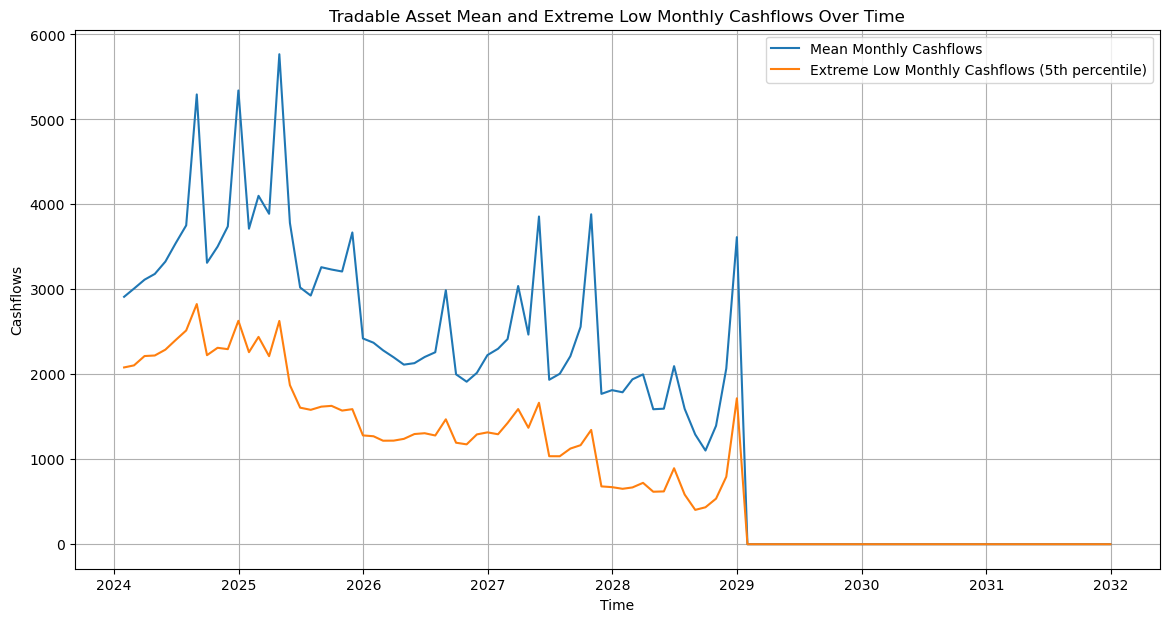

In [38]:
# Tradable Asset Monte Carlo Simulation

# Monte Carlo simulation based on the best fit hyperparameters
num_paths = 1000
num_steps = deviation_free_cash_inflows_df.iloc[:, 4:].shape[1] + 36 # make sure max defer period is considered
forecast_period = 12  # One year forecast period in months
# Initialize arrays to store the results
cashflow_sums = np.zeros(num_paths)
extreme_low_cashflow_sums = np.zeros(num_paths)

# Create a DataFrame to store the monthly cashflows for each path
monthly_cashflows = pd.DataFrame(index=range(num_steps), columns=range(num_paths))

for i in range(num_paths):

    # Calculate the tradable cashflows using the calculate_tradable_cashflow function
    cashflows_df = calculate_tradable_cashflow(deviation_free_cash_inflows_df, best_influence_factor_min, best_influence_factor_max, 
                                               best_defer_rate, best_defer_period_min, best_defer_period_max)
    
    # Sum the cashflows for each month, for the whole portfolio
    simulated_cashflows = cashflows_df.sum(axis=0).values
    
    # Ensure the lengths match by padding with zeros if necessary
    if len(simulated_cashflows) < num_steps:
        padding = np.zeros(num_steps - len(simulated_cashflows))
        simulated_cashflows = np.hstack((simulated_cashflows, padding))
    elif len(simulated_cashflows) > num_steps:
        simulated_cashflows = simulated_cashflows[:num_steps]

    # Store the simulated cashflows for this path
    monthly_cashflows[i] = simulated_cashflows
    
    # Calculate the sum of cashflows for the forecast period (one year)
    if num_steps >= forecast_period:
        cashflow_sums[i] = np.sum(simulated_cashflows[:forecast_period])
    else:
        cashflow_sums[i] = np.sum(simulated_cashflows)

# Calculate the expected one-year cashflow and the extreme low one-year cashflow
expected_one_year_cashflow = np.mean(cashflow_sums)
extreme_low_one_year_cashflow = np.percentile(cashflow_sums, 5)

print("Expected one-year cashflow (Tradabale):", expected_one_year_cashflow)
print("Extreme low one-year cashflow (Tradabale) (5th percentile):", extreme_low_one_year_cashflow)

# Calculate the mean and extreme monthly cashflows for all paths
mean_monthly_cashflows = monthly_cashflows.mean(axis=1)
extreme_low_monthly_cashflows = monthly_cashflows.apply(lambda x: np.percentile(x, 5), axis=1)

# Add time ticker to the monthly cashflow dataframe
monthly_cashflows.index = pd.date_range(start='2024-01-01', periods=num_steps, freq='M')

# Plot the mean and extreme low monthly cashflows over time
plt.figure(figsize=(14, 7))
plt.plot(monthly_cashflows.index, mean_monthly_cashflows, label='Mean Monthly Cashflows')
plt.plot(monthly_cashflows.index, extreme_low_monthly_cashflows, label='Extreme Low Monthly Cashflows (5th percentile)')
plt.xlabel('Time')
plt.ylabel('Cashflows')
plt.title('Tradable Asset Mean and Extreme Low Monthly Cashflows Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Generate Random Asset Investment Plan

In [39]:
# Generate random defaultable and tradable asset investment plan, with start date, end date, and investment amount
num_investment_plans = 10
investment_plans = pd.DataFrame(columns=['Asset_Type', 'Asset_Index', 'Start_Date', 'End_Date', 'Investment_Amount'])
